In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import tensorflow as tf
import tensorflow.keras as keras
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
#Upload input file from local to google colab
from google.colab import files
uploaded = files.upload()

Saving housing.csv to housing.csv


In [5]:
#Read in the housing dataset
cali_housing_data = pd.read_csv("housing.csv")
cali_housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Data Pre Processing

In [6]:
#Get information about columns
cali_housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
cali_housing_data["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

Since there are only 5 Island houses, we will be dropping those rows with Island hosues

In [8]:
cali_housing_data = cali_housing_data[cali_housing_data.ocean_proximity != 'ISLAND']
cali_housing_data["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
Name: ocean_proximity, dtype: int64

Here we can see ocean_proximity is a categorical data

Now we are going to deal with Ocean Proximity. Change it from categorial to numerical, using Ordinal Encoding.

In [9]:
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
cali_housing_data['ocean_proximity'] = encoder.fit_transform(cali_housing_data[['ocean_proximity']])
print(cali_housing_data)

       longitude  latitude  ...  median_house_value  ocean_proximity
0        -122.23     37.88  ...            452600.0              2.0
1        -122.22     37.86  ...            358500.0              2.0
2        -122.24     37.85  ...            352100.0              2.0
3        -122.25     37.85  ...            341300.0              2.0
4        -122.25     37.85  ...            342200.0              2.0
...          ...       ...  ...                 ...              ...
20635    -121.09     39.48  ...             78100.0              1.0
20636    -121.21     39.49  ...             77100.0              1.0
20637    -121.22     39.43  ...             92300.0              1.0
20638    -121.32     39.43  ...             84700.0              1.0
20639    -121.24     39.37  ...             89400.0              1.0

[20635 rows x 10 columns]


In [10]:
cali_housing_data["ocean_proximity"].value_counts()

0.0    9136
1.0    6551
3.0    2658
2.0    2290
Name: ocean_proximity, dtype: int64

Missing Values Analysis

In [11]:
#Check for missing values
cali_housing_data.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [12]:
#Replace missing data with mean
cali_housing_data['total_bedrooms'].fillna(cali_housing_data['total_bedrooms'].mean(), inplace=True)

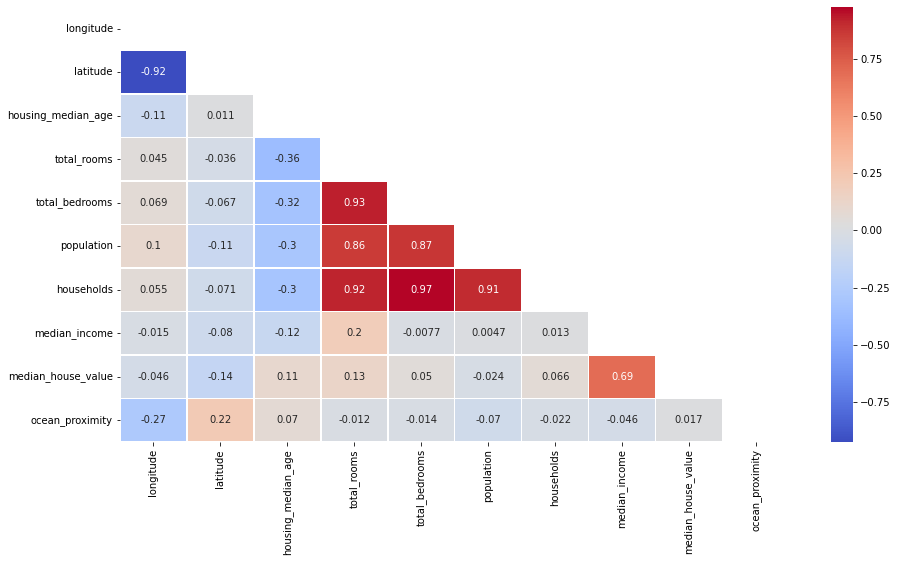

In [13]:
#Obtaining info of the correlations with a heatmap
plt.figure(figsize=(15,8))
corr = cali_housing_data.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(cali_housing_data.corr(), linewidths=.5,annot=True,mask=mask,cmap='coolwarm')

High correlation between households and population

In [14]:
cali_housing_data.drop('households', axis=1, inplace=True)

In [15]:
# Combine total bedroom and rooms per population and remove the original columns for total room and bedrooms
cali_housing_data['avgRooms']=cali_housing_data['total_rooms']/cali_housing_data['population']
cali_housing_data['avgBedrooms']=cali_housing_data['total_bedrooms']/cali_housing_data['population']
#drop original columns
cali_housing_data.drop('total_rooms',axis=1,inplace=True)
cali_housing_data.drop('total_bedrooms',axis=1,inplace=True)

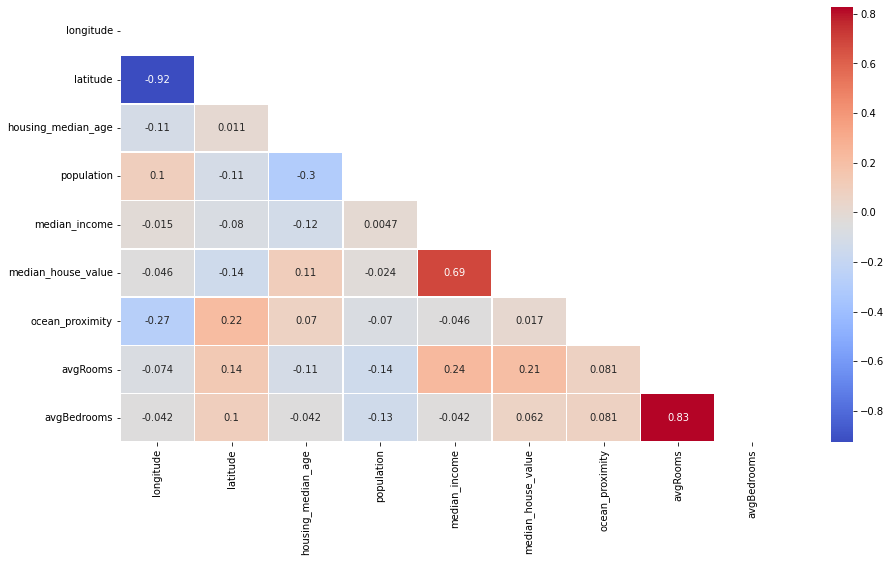

In [16]:
#Obtaining info of the correlations with a heatmap
plt.figure(figsize=(15,8))
corr = cali_housing_data.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(cali_housing_data.corr(), linewidths=.5,annot=True,mask=mask,cmap='coolwarm')

Finding Outliers

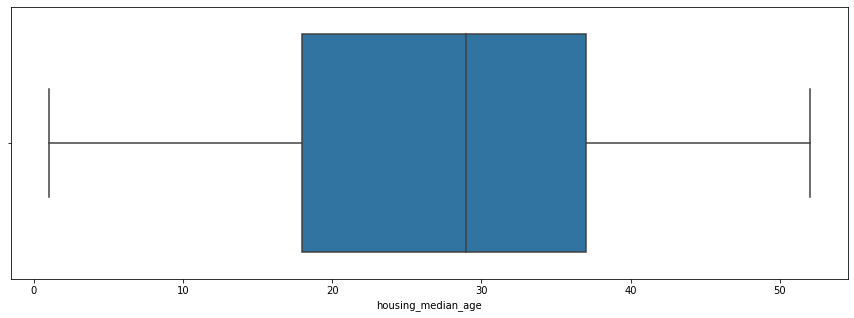

<Figure size 432x288 with 0 Axes>

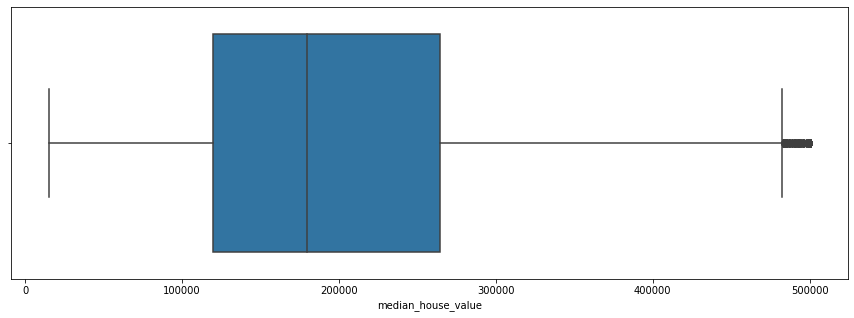

In [17]:
#Finding Outliers
plt.figure(figsize=(15,5))
sns.boxplot(x=cali_housing_data['housing_median_age'])
plt.figure()
plt.figure(figsize=(15,5))
sns.boxplot(x=cali_housing_data['median_house_value'])

Removing the Outliers

In [18]:
cali_housing_data=cali_housing_data.loc[cali_housing_data['median_house_value']<500001,:]

In [19]:
Y = cali_housing_data.median_house_value.values
X = cali_housing_data.drop(['median_house_value'], axis = 1)

Feature Scaling

In [20]:
from sklearn.preprocessing import StandardScaler
#using standard scalar to scale the features
scalar = StandardScaler()
X = scalar.fit_transform(X)

Prepare data for ML Models


In [21]:
#Split train and test data for the model
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

#Linear Regression

In [22]:
#Train the model
from sklearn.linear_model import LinearRegression
linear_regression_model= LinearRegression()
linear_regression_model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [23]:
#Prediction
lr_y_predicted = linear_regression_model.predict(X_test)

Evaluate the model

In [24]:
import sklearn.metrics as metrics

lr_mae = metrics.mean_absolute_error(y_test, lr_y_predicted)
lr_mse = metrics.mean_squared_error(y_test, lr_y_predicted)
lr_rmse = np.sqrt(lr_mse)
lr_r2=metrics.r2_score(y_test,lr_y_predicted)
print("MAE:",lr_mae)
print("MSE:", lr_mse)
print("RMSE:", lr_rmse)
print("R Squared:", lr_r2)

MAE: 47533.34971471665
MSE: 4276798919.605298
RMSE: 65397.23938825933
R Squared: 0.567190052372159


#Random Forest

In [25]:
from sklearn.ensemble import RandomForestRegressor
random_forest_model = RandomForestRegressor(n_estimators=25,max_depth=5)
random_forest_model.fit(X_train,y_train)
#Prediction
rf_y_predicted = random_forest_model.predict(X_test)

Evaluate the model

In [26]:
rf_mae = metrics.mean_absolute_error(y_test, rf_y_predicted)
rf_mse = metrics.mean_squared_error(y_test, rf_y_predicted)
rf_rmse = np.sqrt(rf_mse)
rf_r2=metrics.r2_score(y_test,rf_y_predicted)
print("MAE:",rf_mae)
print("MSE:", rf_mse)
print("RMSE:", rf_rmse)
print("R Squared:", rf_r2)

MAE: 44007.83812700972
MSE: 3654009792.000761
RMSE: 60448.40603358174
R Squared: 0.6302160058407837


#XGBoost

In [27]:
import xgboost as xgb
xg_boost_model = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 1,eta=0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 2000)

xg_boost_model.fit(X_train,y_train)
#Prediction
xg_y_predicted = xg_boost_model.predict(X_test)

[20:29:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Evaluate the model

In [28]:
xg_mae = metrics.mean_absolute_error(y_test, xg_y_predicted)
xg_mse = metrics.mean_squared_error(y_test, xg_y_predicted)
xg_rmse = np.sqrt(xg_mse)
xg_r2=metrics.r2_score(y_test,xg_y_predicted)
print("MAE:",xg_mae)
print("MSE:", xg_mse)
print("RMSE:", xg_rmse)
print("R Squared:", xg_r2)

MAE: 27445.425404923422
MSE: 1658919828.9722984
RMSE: 40729.83954022282
R Squared: 0.8321181290509326


*Out of all the ML models we can see that the XGBoost provides the best performace i.e. lowest MAE and highest R Squared value.*

#Deep Learning Model

In [29]:
#Setting up the packages to build our models
from keras.models import Sequential
from keras.layers import Dense

**Single Hidden Layer Model**

In [51]:
    input_shape = X_train.shape[1]
    single_layer_model= Sequential()
    single_layer_model.add(Dense(64, activation="swish",input_shape = [input_shape,]))
    single_layer_model.add(Dense(1))
    opt = keras.optimizers.Adam(learning_rate=0.01)
    single_layer_model.compile(optimizer= opt, loss='mse', metrics = ['mae', 'mse'])
    history_singleLayer= single_layer_model.fit(X_train,y_train,validation_split=0.1, epochs=500, batch_size=32,
                                            callbacks=[keras.callbacks.EarlyStopping(patience=10)],verbose=1)

Epoch 1/500
443/443 [==============================] - 1s 2ms/step - loss: 45994643456.0000 - mae: 191332.5312 - mse: 45994643456.0000 - val_loss: 45466165248.0000 - val_mae: 189722.1250 - val_mse: 45466165248.0000
Epoch 2/500
443/443 [==============================] - 1s 2ms/step - loss: 43564019712.0000 - mae: 185655.2188 - mse: 43564019712.0000 - val_loss: 41970139136.0000 - val_mae: 181465.9219 - val_mse: 41970139136.0000
Epoch 3/500
443/443 [==============================] - 1s 2ms/step - loss: 39288496128.0000 - mae: 175148.8594 - mse: 39288496128.0000 - val_loss: 37028859904.0000 - val_mae: 169036.9062 - val_mse: 37028859904.0000
Epoch 4/500
443/443 [==============================] - 1s 2ms/step - loss: 33971974144.0000 - mae: 160996.6875 - mse: 33971974144.0000 - val_loss: 31422904320.0000 - val_mae: 153548.9844 - val_mse: 31422904320.0000
Epoch 5/500
443/443 [==============================] - 1s 2ms/step - loss: 28342499328.0000 - mae: 144402.3594 - mse: 28342499328.0000 - val

Evaluate the model

In [53]:
best_score = min(history_singleLayer.history['val_mae'])

print(best_score)

35734.66015625


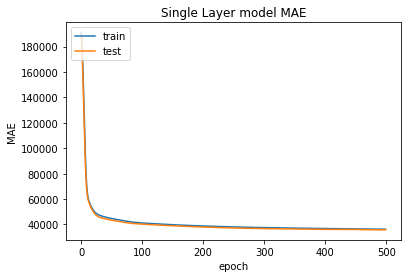

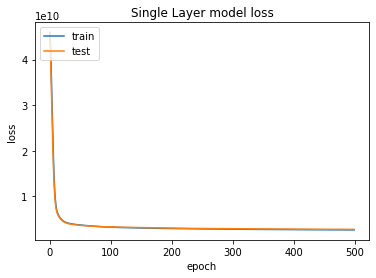

In [54]:
#Plot the learning curve
# summarize history for accuracy
plt.plot(history_singleLayer.history['mae'])
plt.plot(history_singleLayer.history['val_mae'])
plt.title('Single Layer model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_singleLayer.history['loss'])
plt.plot(history_singleLayer.history['val_loss'])
plt.title('Single Layer model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

*Even with a single hidden layer Deep Learning model we are getting better performance than Linear Regression and Random Forest ML models. From the graph above we can see that our model is really balanced performing well on both train and test datasets*

**Multiple Hidden Layer Model**

In [61]:
    from keras.layers import Dropout
    multi_layer_model= Sequential()
    multi_layer_model.add(Dense(64, activation="swish",input_shape = [input_shape,]))
    multi_layer_model.add(Dense(64, activation="swish"))
    multi_layer_model.add(Dense(32, activation="swish"))
    multi_layer_model.add(Dense(1))
    opt = keras.optimizers.Adam(learning_rate=0.001)
    multi_layer_model.compile(optimizer= opt, loss='mse', metrics = ['mae', 'mse'])
    history_multiLayer= multi_layer_model.fit(X_train,y_train,validation_split=0.1, epochs=500, batch_size=32,
                                                callbacks=[keras.callbacks.EarlyStopping(patience=10)],verbose=1)

Epoch 1/500
443/443 [==============================] - 2s 3ms/step - loss: 42678726656.0000 - mae: 182969.4062 - mse: 42678726656.0000 - val_loss: 28342065152.0000 - val_mae: 144441.0000 - val_mse: 28342065152.0000
Epoch 2/500
443/443 [==============================] - 1s 2ms/step - loss: 11660453888.0000 - mae: 79078.8438 - mse: 11660453888.0000 - val_loss: 6271438336.0000 - val_mae: 56873.7188 - val_mse: 6271438336.0000
Epoch 3/500
443/443 [==============================] - 1s 2ms/step - loss: 5965459456.0000 - mae: 55858.7695 - mse: 5965459456.0000 - val_loss: 5238499840.0000 - val_mae: 52524.8594 - val_mse: 5238499840.0000
Epoch 4/500
443/443 [==============================] - 1s 2ms/step - loss: 5078119424.0000 - mae: 51963.0117 - mse: 5078119424.0000 - val_loss: 4659294720.0000 - val_mae: 49131.2969 - val_mse: 4659294720.0000
Epoch 5/500
443/443 [==============================] - 1s 2ms/step - loss: 4536539136.0000 - mae: 49276.7656 - mse: 4536539136.0000 - val_loss: 4300490752.0

Evaluate the model

In [62]:
best_score = min(history_multiLayer.history['val_mae'])

print(best_score)

33351.88671875


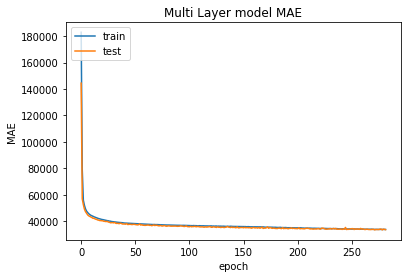

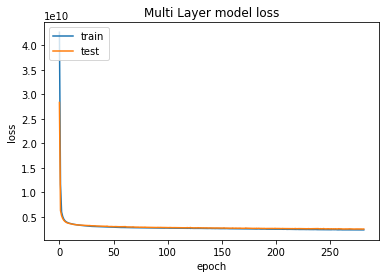

In [63]:
#Plot the learning curve
# summarize history for accuracy
plt.plot(history_multiLayer.history['mae'])
plt.plot(history_multiLayer.history['val_mae'])
plt.title('Multi Layer model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_multiLayer.history['loss'])
plt.plot(history_multiLayer.history['val_loss'])
plt.title('Multi Layer model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

*Using more complex model i.e. a deep learning model with multiple hidden layers we are getting slightly better result than our single layer model. However XGBoost is performing better than both of the deep learning models with a lower MAE*